In [40]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, to_date, split, when, coalesce
from pyspark.sql.types import MapType, StringType

In [41]:
spark = SparkSession.builder \
                    .appName('tennis') \
                    .getOrCreate()

# Singles

In [42]:
singles=spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')

singles.show(2)

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+--------------+-----------+---------+----------+----------+--------+----------+-----------+-------------+----------+--------+---------+---------+-----------+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|   winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|   loser_name|loser_hand|loser_ht|loser_ioc|loser_age|      score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+-

In [43]:
from pyspark.sql.functions import col, count, round

singles = singles.withColumn('winner_entry', when(singles['winner_entry'].isNull(), "Standard").otherwise(singles['winner_entry']))
singles = singles.withColumn('loser_entry', when(singles['loser_entry'].isNull(), "Standard").otherwise(singles['loser_entry']))

null_counts = singles.select([round(((count(when(col(c).isNull(), c)) / singles.count()) * 100), 1).alias(c) for c in singles.columns])
null_counts.show()

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+-----------+-----------+---------+----------+----------+--------+----------+-----------+----------+----------+--------+---------+---------+-----+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|loser_name|loser_hand|loser_ht|loser_ioc|loser_age|score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+----------+------------+-

In [44]:
selected_columns = ['surface',
                    'tourney_level',
                    'tourney_name',
                    'draw_size',
                    'winner_name',
                    'winner_hand', 
                    'winner_ht',
                    'winner_ioc',
                    'winner_age',
                    'loser_name',
                    'loser_hand',
                    'loser_ioc',
                    'winner_entry',
                    'loser_entry',
                    'loser_age',
                    'best_of',
                    'round',
                    'winner_rank',
                    'loser_rank'
                   ]

clean_df = singles.select(selected_columns)
clean_df = clean_df.filter(clean_df['best_of'] != 1)
clean_df = clean_df.dropna()
clean_df.show(2)

+-------+-------------+------------+---------+-------------+-----------+---------+----------+----------+-------------+----------+---------+------------+-----------+---------+-------+-----+-----------+----------+
|surface|tourney_level|tourney_name|draw_size|  winner_name|winner_hand|winner_ht|winner_ioc|winner_age|   loser_name|loser_hand|loser_ioc|winner_entry|loser_entry|loser_age|best_of|round|winner_rank|loser_rank|
+-------+-------------+------------+---------+-------------+-----------+---------+----------+----------+-------------+----------+---------+------------+-----------+---------+-------+-----+-----------+----------+
|   Hard|            A|    Adelaide|       32|Thomas Muster|          L|      180|       AUT|      26.2|Bryan Shelton|         R|      USA|    Standard|   Standard|     28.0|      3|  R32|          9|        97|
|   Hard|            A|    Adelaide|       32| Brett Steven|          R|      185|       NZL|      24.6|  Byron Black|         R|      ZIM|    Standard|

In [45]:
clean_df.dtypes

[('surface', 'string'),
 ('tourney_level', 'string'),
 ('tourney_name', 'string'),
 ('draw_size', 'int'),
 ('winner_name', 'string'),
 ('winner_hand', 'string'),
 ('winner_ht', 'int'),
 ('winner_ioc', 'string'),
 ('winner_age', 'double'),
 ('loser_name', 'string'),
 ('loser_hand', 'string'),
 ('loser_ioc', 'string'),
 ('winner_entry', 'string'),
 ('loser_entry', 'string'),
 ('loser_age', 'double'),
 ('best_of', 'int'),
 ('round', 'string'),
 ('winner_rank', 'int'),
 ('loser_rank', 'int')]

In [55]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
import scipy.stats as stats
import pandas as pd
from sklearn import preprocessing

df = clean_df.toPandas()
le = preprocessing.LabelEncoder()
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [73]:
correlation_matrix_list = []

for a in clean_df.dtypes:
    print(a)
    correlation_list = []

    for b in clean_df.dtypes:
        #print(b)
        
        if a[1] == b[1] and a[1] == 'string':
            confusion_matrix = pd.crosstab(df[a[0]], df[b[0]])
            correlacao = cramers_v(confusion_matrix.values)
                            
        if a[1] == b[1] and a[1] == 'int':
            #features = [a[0], b[0]]  # List of column names
            correlacao = df[a[0]].corr(df[b[0]])

        if a[1] != b[1]:
            df[a[0]] = le.fit_transform(df[a[0]])
            df[b[0]]= le.fit_transform(df[b[0]])

            correlacao = stats.pointbiserialr(df[a[0]], df[b[0]])[0]
        
        correlation_list.append(correlacao)

    correlation_matrix_list.append(correlation_list)

('surface', 'string')
('tourney_level', 'string')
('tourney_name', 'string')
('draw_size', 'int')
('winner_name', 'string')
('winner_hand', 'string')
('winner_ht', 'int')
('winner_ioc', 'string')
('winner_age', 'double')
('loser_name', 'string')
('loser_hand', 'string')
('loser_ioc', 'string')
('winner_entry', 'string')
('loser_entry', 'string')
('loser_age', 'double')
('best_of', 'int')
('round', 'string')
('winner_rank', 'int')
('loser_rank', 'int')


Fizemos diferentes correlações dependendo do tipo da variável.

In [76]:
#from pyspark.ml.feature import StringIndexer
#from functools import reduce

#def transform_column(df, col_mapping):
 #   string_indexer = StringIndexer(inputCol=col_mapping['inputCol'], outputCol=col_mapping['outputCol'])
  #  return string_indexer.fit(df).transform(df)

#index_columns = [
 #   {'inputCol': 'winner_ioc', 'outputCol': 'winner_country_id'},
  #  {'inputCol': 'loser_ioc', 'outputCol': 'loser_country_id'},
   # {'inputCol': 'winner_hand', 'outputCol': 'winner_hand_id'},
    #{'inputCol': 'loser_hand', 'outputCol': 'loser_hand_id'},
    #{'inputCol': 'round', 'outputCol': 'round_id'},
    #{'inputCol': 'tourney_level', 'outputCol': 'tourney_level_id'},
    #{'inputCol': 'surface', 'outputCol': 'surface_id'},
    #{'inputCol': 'tourney_name', 'outputCol': 'tourney_name_id'},
    #{'inputCol': 'winner_entry', 'outputCol': 'winner_entry_id'}
#]

#indexed_df = reduce(lambda df, col_mapping: transform_column(df, col_mapping), index_columns, clean_df)


#def cast_to_int(column_name):
 #   return col(column_name).cast("int")

#columns = indexed_df.columns

#casted_df = indexed_df.select(*map(cast_to_int, columns))

#columns_to_drop = ['winner_ioc', 'loser_ioc', 'winner_hand', 'loser_hand', 'round', 'tourney_level', 'surface', 'tourney_name', 'winner_entry']
#casted_df = casted_df.drop(*columns_to_drop)

#casted_df.show(3)

NameError: name 'casted_df' is not defined

In [20]:
#from pyspark.ml.stat import ChiSquareTest
#from pyspark.ml.feature import VectorAssembler

#assembler = VectorAssembler(inputCols=['winner_hand_id', 'loser_hand_id'], outputCol='features')
#feature_vector = assembler.transform(casted_df).select('features')

# Calculate chi-squared test
#chi_square_test = ChiSquareTest.test(feature_vector, 'features')

# Show the result
#chi_square_test.show(truncate=False)


TypeError: ChiSquareTest.test() missing 1 required positional argument: 'labelCol'

In [34]:
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.stat import Correlation

#assembler = VectorAssembler(inputCols=casted_df.columns, outputCol="features")
#assembled_df = assembler.transform(casted_df).select("features")

#correlation_matrix = Correlation.corr(assembled_df, "features").head()

#correlation_matrix_array = correlation_matrix[0].toArray()

#correlation_matrix_list = correlation_matrix_array.tolist()

#print(correlation_matrix_list)


[[1.0, 0.02392239461731851, 0.03623073866766813, 0.0255476902239902, 0.024269401203414656, 0.02882318127625064, 0.8303627500197317, 0.22042125252237893, 0.17834146711829288, 0.19025141197051615, 0.21001997757358498, -0.11033348292597803, -0.08447558380435066, -0.033040554726984375, -0.022896292655078497, -0.012104002563878644, -0.007181207430868519, 0.12101167240567821, 0.7669487867323765, -0.07745162294672409, -0.5222026936657728, -0.04415279491769547], [0.02392239461731851, 1.0, 0.05410040441361001, -0.20342659618054504, 0.36079094006367013, 0.07993658054654049, 0.004766113851958011, 0.007052962609695003, 0.009201015723717532, -0.020945356431838685, -0.027321585955599297, 0.011884944180864904, -0.007532313679656683, 0.030492177475086254, 0.037682457660535844, -0.019985402274193802, 0.0009344029225006071, 0.050115783429165124, 0.03864618205871084, -0.07309920610166648, 0.07697776578312511, 0.040045354113885566], [0.03623073866766813, 0.05410040441361001, 1.0, -0.017652719892560568, 0.

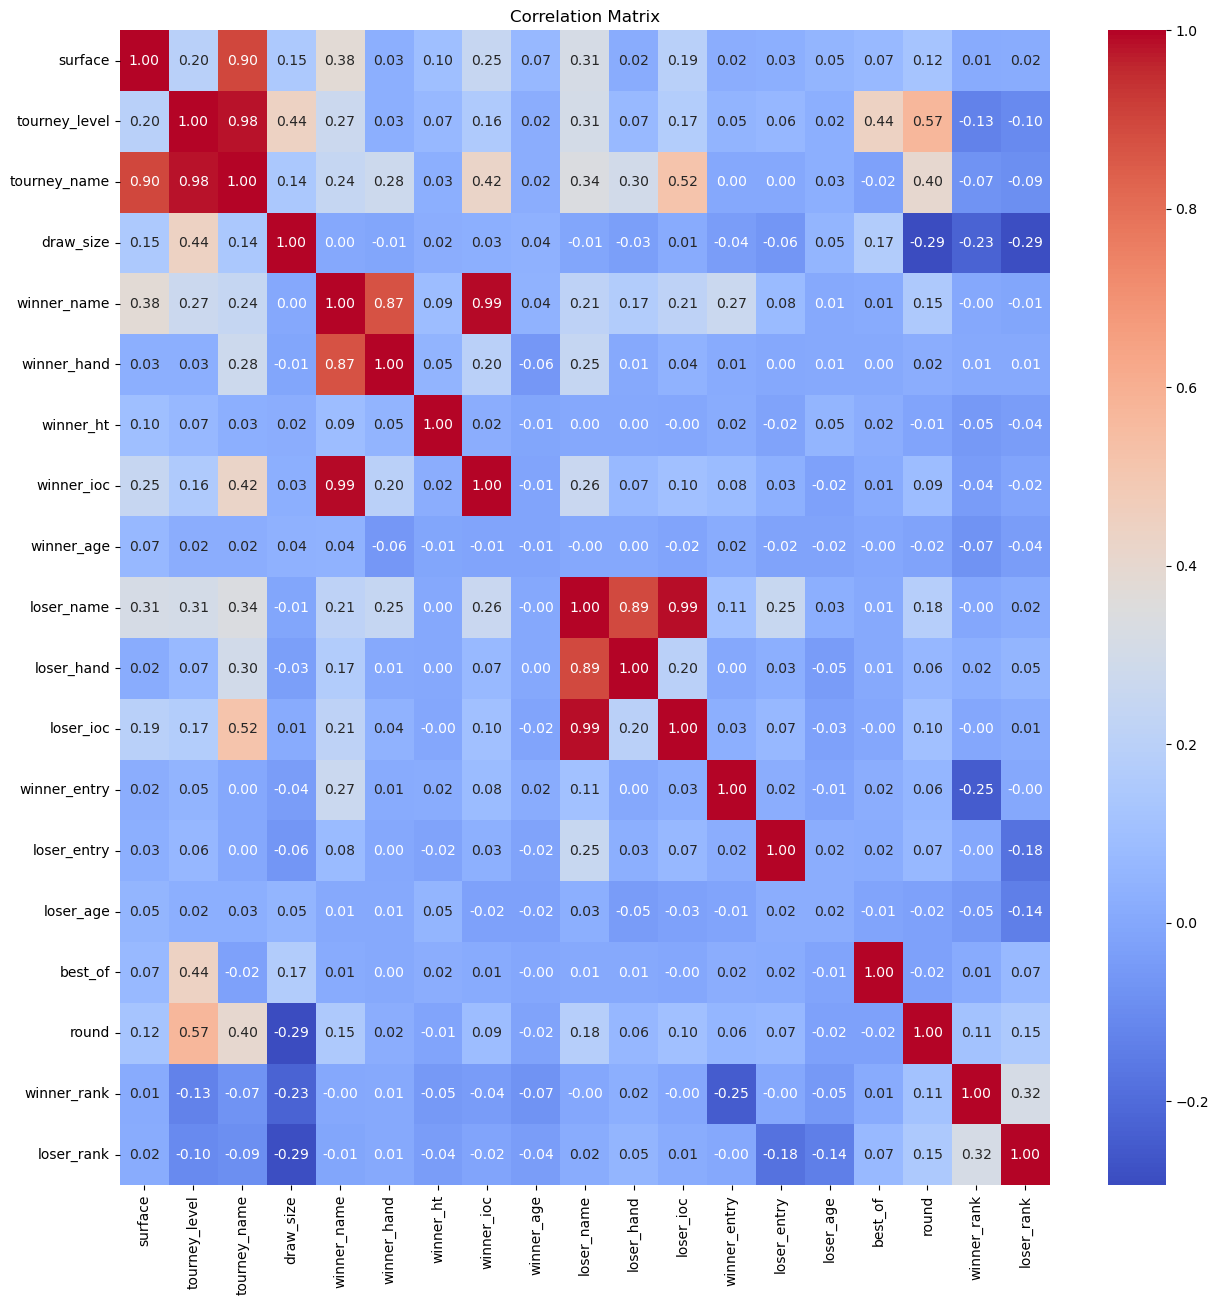

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

column_names = clean_df.columns

correlation_matrix_array = np.array(correlation_matrix_list)

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_array, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=90)
plt.yticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=0)
plt.show()

#matriz de correlação das variaveis para o modelo de ml

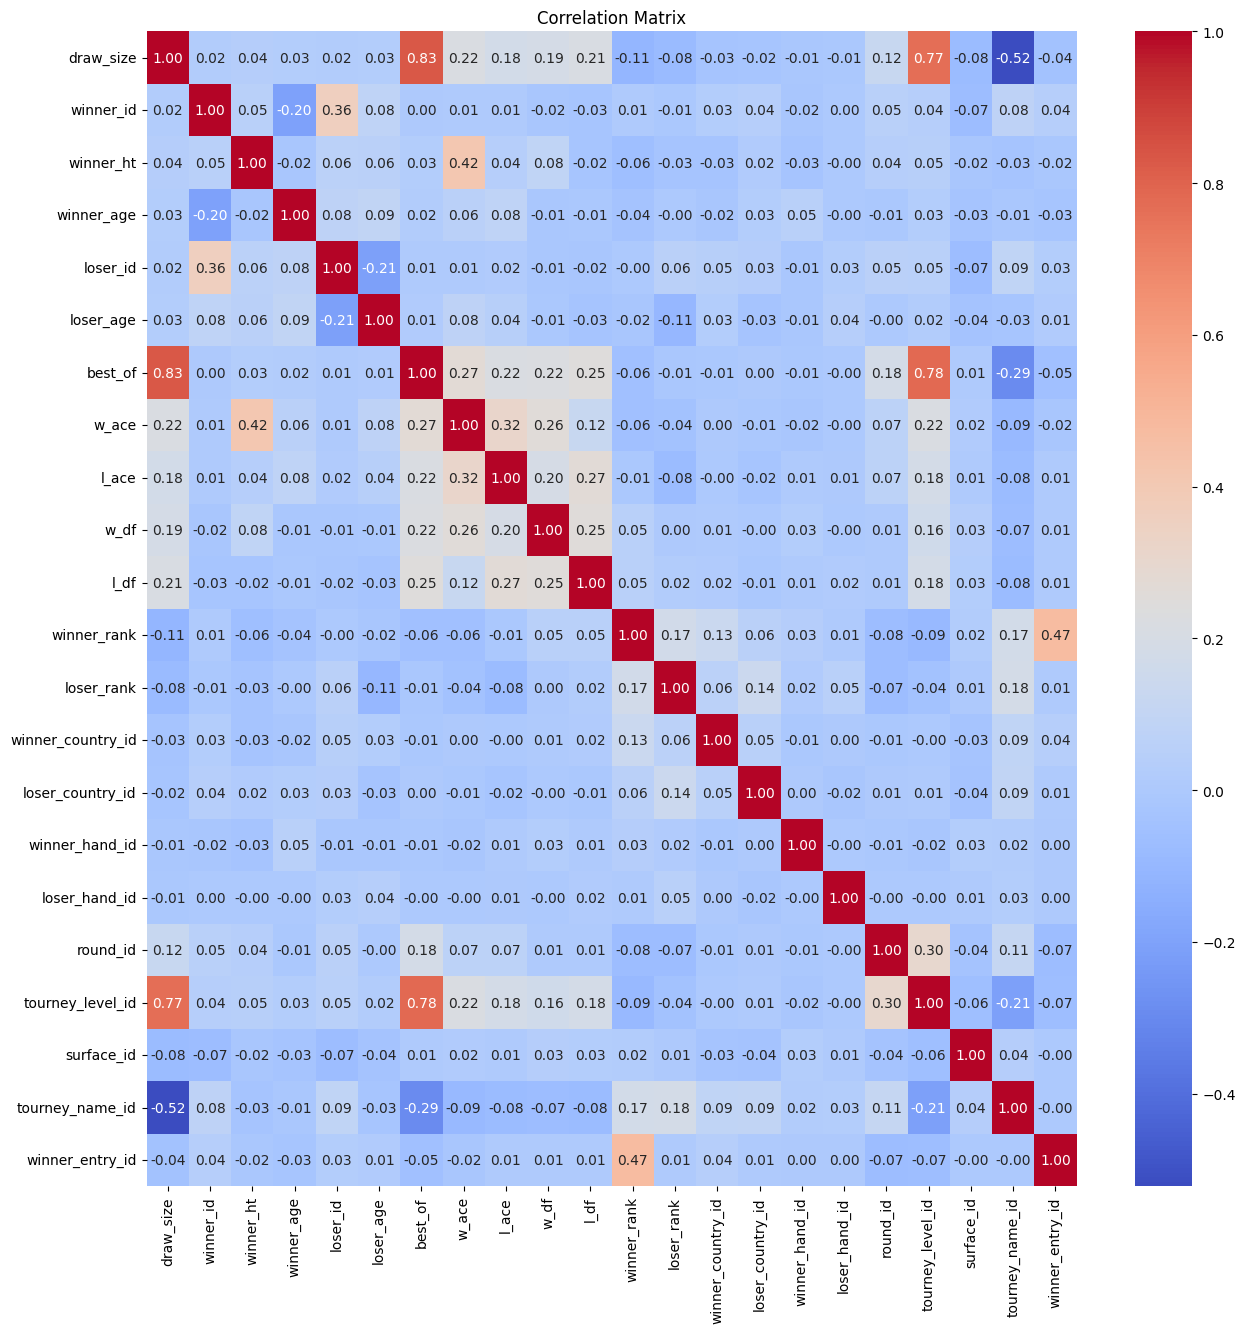

In [35]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

#column_names = casted_df.columns

#correlation_matrix_array = np.array(correlation_matrix_list)

#plt.figure(figsize=(15, 15))
#sns.heatmap(correlation_matrix_array, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Correlation Matrix')
#plt.xticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=90)
#plt.yticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=0)
#plt.show()

# Doubles

In [ ]:
doubles=spark.read.option("header","true").option("inferSchema","true") \
.csv('doubles')

doubles.show(2)

+----------+------------+-------+---------+-------------+------------+---------+----------+----------+-----------+------------+---------+---------+----------+-----------+----------+-------+-----+--------------+------------+----------+-----------+-------------+--------------+------------+----------+-----------+-------------+---------------+-----------+---------+----------+-------------+---------------+-----------+---------+----------+-------------+------------+-------------------+------------+-------------------+-----------+------------------+-----------+------------------+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner1_id|winner2_id|winner_seed|winner_entry|loser1_id|loser2_id|loser_seed|loser_entry|     score|best_of|round|  winner1_name|winner1_hand|winner1_ht|winner1_ioc|  winner1_age|  winner

In [ ]:
from pyspark.sql.functions import col, count, round

null_counts = doubles.select([round(((count(when(col(c).isNull(), c)) / doubles.count()) * 100), 1).alias(c) for c in doubles.columns])
null_counts.show()

+----------+------------+-------+---------+-------------+------------+---------+----------+----------+-----------+------------+---------+---------+----------+-----------+-----+-------+-----+------------+------------+----------+-----------+-----------+------------+------------+----------+-----------+-----------+-----------+-----------+---------+----------+----------+-----------+-----------+---------+----------+----------+------------+-------------------+------------+-------------------+-----------+------------------+-----------+------------------+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner1_id|winner2_id|winner_seed|winner_entry|loser1_id|loser2_id|loser_seed|loser_entry|score|best_of|round|winner1_name|winner1_hand|winner1_ht|winner1_ioc|winner1_age|winner2_name|winner2_hand|winner2_ht|winner2

In [ ]:
selected_columns = ['surface',
                    'tourney_level',
                    'match_num',
                    'winner1_id',
                    'winner2_id',
                    'winner1_hand', 
                    'winner2_hand', 
                    'winner1_ht',
                    'winner2_ht',
                    'winner1_ioc',
                    'winner2_ioc',
                    'winner1_age', 
                    'winner2_age', 
                    'winner1_rank', 
                    'winner2_rank', 
                    'loser1_id',
                    'loser2_id'
                    'loser1_hand',
                    'loser2_hand',
                    'loser1_ht',
                    'loser2_ht',
                    'loser1_ioc',
                    'loser2_ioc',
                    'loser1_age',
                    'loser2_age',
                    'loser1_rank',
                    'loser2_rank',
                    'best_of',
                    'round'
                   ]

clean_df = doubles.select(selected_columns)
clean_df = clean_df.dropna()
clean_df.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `loser2_idloser1_hand` cannot be resolved. Did you mean one of the following? [`loser1_hand`, `loser2_hand`, `loser1_ht`, `loser1_rank`, `loser2_id`].;
'Project [surface#236339, tourney_level#236341, match_num#236343, winner1_id#236344, winner2_id#236345, winner1_hand#236356, winner2_hand#236361, winner1_ht#236357, winner2_ht#236362, winner1_ioc#236358, winner2_ioc#236363, winner1_age#236359, winner2_age#236364, winner1_rank#236375, winner2_rank#236377, loser1_id#236348, 'loser2_idloser1_hand, loser2_hand#236371, loser1_ht#236367, loser2_ht#236372, loser1_ioc#236368, loser2_ioc#236373, loser1_age#236369, loser2_age#236374, ... 4 more fields]
+- Relation [tourney_id#236337,tourney_name#236338,surface#236339,draw_size#236340,tourney_level#236341,tourney_date#236342,match_num#236343,winner1_id#236344,winner2_id#236345,winner_seed#236346,winner_entry#236347,loser1_id#236348,loser2_id#236349,loser_seed#236350,loser_entry#236351,score#236352,best_of#236353,round#236354,winner1_name#236355,winner1_hand#236356,winner1_ht#236357,winner1_ioc#236358,winner1_age#236359,winner2_name#236360,... 41 more fields] csv
